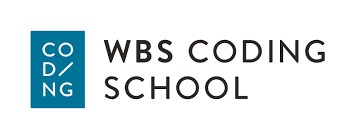

# <span style="color:red">**Final Project**</span>

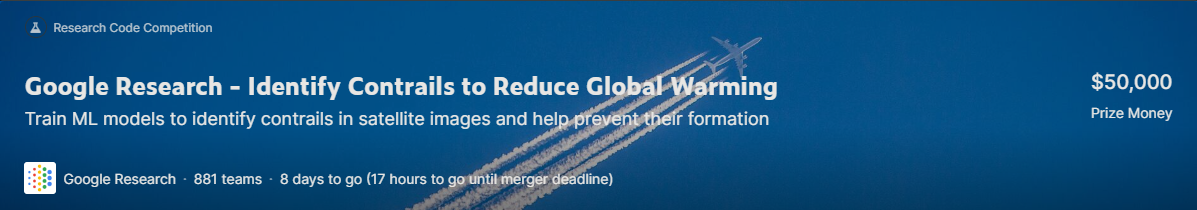

In [1]:
# !pip install segmentation-models --no-index --find-links=file:///kaggle/input/packages/segmentation_models/
# !pip install -q albumentations
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import math
import keras.backend as K
import segmentation_models as sm
import gc 
import albumentations as A
import json
import tensorflow as tf
from tensorflow.python.keras import losses
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.utils import Sequence

Segmentation Models: using `tf.keras` framework.


In [2]:
DO_TRAINING = False
PREPROCESS_DATA = False
DO_SUBMISSION = True

# Config


In [3]:
# do you want to use a custom filter or the default ash filter
custom_filter = True

# Change new_dim to resize images (this shoul be multiples of 32 like (384, 384) or (512, 512))
new_dim = (256, 256)

EPOCHS = 25

batch_size = 6

N_AUG = int(batch_size/2) #Number of augmentated images per batch

LR = 0.0015 #initial lr

# change this for other backbones
backbone_name = 'efficientnetb0'    
encoder_weights='/kaggle/input/efficientnetb0b7-keras-weights/efficientnet-b0_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5'

N_TIMES_BEFORE = 4
N_TIMES = 8
N_CHANNELS = 3

# change this if you want to use other pretrained weights
weights_to_load = 'best_checkpoint.h5'

In [4]:
TRAIN_DIR = '/kaggle/input/google-research-identify-contrails-reduce-global-warming/train'
VAL_DIR = '/kaggle/input/google-research-identify-contrails-reduce-global-warming/validation'
TEST_DIR = '/kaggle/input/google-research-identify-contrails-reduce-global-warming/test'
BASE_DIR = '/kaggle/input/google-research-identify-contrails-reduce-global-warming'
LIB_DIR = '/kaggle/input/library'
OUTPUT_DIR = '/kaggle/working'
weights = 'best_checkpoint.h5'


if new_dim != (256, 256):
    resizing = True

#### fast data loader


In [5]:
# faster loading
class fastnp:
    def load(file):
        file=open(file,"rb")
        header = file.read(128)
        descr = str(header[19:25], 'utf-8').replace("'","").replace(" ","")
        shape = tuple(int(num) for num in str(header[60:120], 'utf-8').replace(', }', '').replace('(', '').replace(')', '').split(','))
        datasize = np.lib.format.descr_to_dtype(descr).itemsize
        for dimension in shape:
            datasize *= dimension
        return np.ndarray(shape, dtype=descr, buffer=file.read(datasize))

# Preprocessing

In [6]:
# custom filter
if custom_filter:
    def apply_filter(id, DIR=TEST_DIR):
        with open(os.path.join(DIR, id, 'band_11.npy'), 'rb') as f:
            band11 = np.load(f)[...,N_TIMES_BEFORE]
        with open(os.path.join(DIR, id, 'band_12.npy'), 'rb') as f:
            band12 = np.load(f)[...,N_TIMES_BEFORE]
        with open(os.path.join(DIR, id, 'band_13.npy'), 'rb') as f:
            band13 = np.load(f)[...,N_TIMES_BEFORE]    
        with open(os.path.join(DIR, id, 'band_14.npy'), 'rb') as f:
            band14 = np.load(f)[...,N_TIMES_BEFORE]
        with open(os.path.join(DIR, id, 'band_15.npy'), 'rb') as f:
            band15 = np.load(f)[...,N_TIMES_BEFORE]

        def normalize_range(data):
            """Maps data to the range [0, 1]."""
            data**2
            mn = data.min()
            mx = data.max()
            return (data-mn) / (mx-mn)    

        # c = t_diff(band15 - band14, _TDIFF_BOUNDS)
        r = normalize_range(band15-band13)
        g = normalize_range(band14-band11)
        b = normalize_range(band15-band12)

        return np.stack([r, g, b], axis=2)

# default ash filter
else:

    _T11_BOUNDS = (243, 303)
    _CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
    _TDIFF_BOUNDS = (-4, 2)

    def apply_filter(id,TEST_DIR=TEST_DIR):
        with open(os.path.join(TEST_DIR, id, 'band_11.npy'), 'rb') as f:
            band11 = np.load(f)[...,N_TIMES_BEFORE]
        with open(os.path.join(TEST_DIR, id, 'band_14.npy'), 'rb') as f:
            band14 = np.load(f)[...,N_TIMES_BEFORE]
        with open(os.path.join(TEST_DIR, id, 'band_15.npy'), 'rb') as f:
            band15 = np.load(f)[...,N_TIMES_BEFORE]

        def normalize_range(data, bounds):
            """Maps data to the range [0, 1]."""
            return (data - bounds[0]) / (bounds[1] - bounds[0])

        r = normalize_range(band15 - band14, _TDIFF_BOUNDS)
        g = normalize_range(band14 - band11, _CLOUD_TOP_TDIFF_BOUNDS)
        b = normalize_range(band14, _T11_BOUNDS)
        false_color = np.clip(np.stack([r, g, b], axis=2), 0, 1)
        return false_color

In [7]:
if PREPROCESS_DATA:

    def process_data(label):
        dir_list = os.listdir(os.path.join(BASE_DIR, label))
        for id in dir_list:
            img = apply_filter(id)
            os.makedirs(os.path.join(OUTPUT_DIR, label, id))
            np.save(os.path.join(OUTPUT_DIR, label, id, 'image.npy'), img)
            np.save(os.path.join(OUTPUT_DIR, label, id, 'human_pixel_masks.npy'), np.load(os.path.join(OUTPUT_DIR, label, id, 'human_pixel_masks.npy')))

    process_data('train')
    process_data('validation')
    TEST_DIR = os.path.join(OUTPUT_DIR, 'train')
    VAL_DIR = os.path.join(OUTPUT_DIR, 'validation')    

# creating a model

In [8]:
def DiceLoss(targets, inputs, smooth=1e-6):
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)    
    intersection = K.sum(K.dot(targets, inputs))
    dice = (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    return 1 - dice

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def weighted_BCE_loss(y_true, y_pred, positive_weight=5):
    y_pred = K.clip(y_pred, min_value=1e-12, max_value=1 - 1e-12)
    weights = K.ones_like(y_pred)
    weights = tf.where(y_pred < 0.5, positive_weight * weights, weights)
    out = losses.binary_crossentropy(y_true, y_pred)
    out = K.expand_dims(out, axis=-1) * weights 
    return K.mean(out)

In [ ]:
train_len = len(os.listdir(TRAIN_DIR))
val_len = len(os.listdir(VAL_DIR))

steps_per_epoch = int(np.ceil(train_len / batch_size))
validation_steps = int(np.ceil(val_len / batch_size))

In [ ]:
dice_loss = sm.losses.DiceLoss()
# bce_dice = sm.losses.bce_dice_loss
# focal_loss = sm.losses.BinaryFocalLoss()
# total_loss = dice_loss + (1 * focal_loss)
# bce = sm.losses.binary_crossentropy

lr_decayed_fn = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=LR, decay_steps=steps_per_epoch, decay_rate=0.94
)

metrics = [dice_coefficient, sm.metrics.IOUScore(threshold=0.5)]

optimizer = Adam(
    learning_rate=lr_decayed_fn
)

model = sm.Unet(backbone_name=backbone_name ,input_shape=(None, None, 3),
                classes = 1,
                activation='sigmoid', encoder_weights=encoder_weights)

model.compile(loss=dice_loss, optimizer=optimizer, metrics=metrics)

# DataLoader

In [ ]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, batch_size=batch_size, dim=(256,256), label='train', shuffle=True, N_AUG=N_AUG):
        'Initialization'
        self.batch_size = batch_size
        self.dim = dim
        self.label = label
        self.dir = os.path.join(BASE_DIR, label)
        self.list_IDs = os.listdir(self.dir)
        self.shuffle = shuffle
        self.N_AUG = N_AUG
        with open(LIB_DIR + '/ids_with_contrails.json', 'r') as f:
                self.ids_w_con = json.load(f)
        self.on_epoch_end()
 
    def __len__(self):
        'Denotes the number of batches per epoch'

        return int(np.ceil(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        indexes_2 = self.indexes_2[index*self.N_AUG:(index+1)*self.N_AUG]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]                

        # add ids augumented images
        if not self.label == 'validation':
            list_IDs_2_temp = [self.ids_w_con[k] for k in indexes_2]

            X, y = self.__data_generation(list_IDs_temp + list_IDs_2_temp)
        else:
            X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        self.indexes_2 = np.arange(len(self.ids_w_con))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            np.random.shuffle(self.indexes_2)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Augmentations
        if resizing:
            transform = A.Compose([
            A.OneOf([
                A.HorizontalFlip(p=1.0),
                A.VerticalFlip(p=1.0),
                A.Rotate(p=1.0)
            ]),  
            A.Resize(*self.dim) 
            ])
        else:
            transform = A.Compose([
            A.OneOf([
                A.HorizontalFlip(p=1.0),
                A.VerticalFlip(p=1.0),
                A.Rotate(p=1.0)
            ]), 
            ])      
        resize = A.Resize(*self.dim) 

        # Initialization
        X = np.empty((len(list_IDs_temp), *self.dim, 3))
        y = np.empty((len(list_IDs_temp), *self.dim, 1))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            if PREPROCESS_DATA:
                if i < self.batch_size:
                    
                    if resizing:

                        resized = resize(image=fastnp.load(os.path.join(self.dir,  ID, 'image.npy')), 
                                        mask=fastnp.load(os.path.join(self.dir,  ID, 'human_pixel_masks.npy')))
                        X[i,] = resized['image']
                        y[i,] = resized['mask']

                    else:

                        X[i,] = fastnp.load(os.path.join(self.dir,  ID, 'image.npy'))
                        y[i,] = fastnp.load(os.path.join(self.dir,  ID, 'human_pixel_masks.npy'))

                else:

                    transformed = transform(image=fastnp.load(os.path.join(self.dir,  ID, 'image.npy')), 
                                            mask=fastnp.load(os.path.join(self.dir,  ID, 'human_pixel_masks.npy')))
                    X[i,] = transformed['image']
                    y[i,] = transformed['mask']

            else:

                if i < self.batch_size:

                    img = apply_filter(ID, self.dir)

                    if resizing:

                        resized = resize(image=img, mask=fastnp.load(os.path.join(self.dir,  ID, 'human_pixel_masks.npy')))
                        X[i,] = resized['image']
                        y[i,] = resized['mask']

                    else:

                        X[i,] = img
                        y[i,] = fastnp.load(os.path.join(self.dir,  ID, 'human_pixel_masks.npy'))
                    
                else:

                    img = apply_filter(ID, self.dir)
                    transformed = transform(image=img, mask=fastnp.load(os.path.join(self.dir,  ID, 'human_pixel_masks.npy')))
                    X[i,] = transformed['image']
                    y[i,] = transformed['mask']

        return X, y

In [ ]:
train_ds = DataGenerator(batch_size=batch_size, dim=new_dim)
valid_ds = DataGenerator(batch_size=batch_size, dim=new_dim, label='validation', shuffle=False)

In [ ]:
print(f'Training  batches  have  the  shape: {train_ds[0][0].shape}')
print(f'Validation batches have  the  shape: {valid_ds[0][0].shape}')

(9, 384, 384, 3)

In [ ]:
def process_test_batch(pred_ls, DIR=VAL_DIR):

    data = np.zeros(shape=(len(pred_ls), *new_dim, N_CHANNELS),dtype="float32")
    for i, ID in enumerate(pred_ls):
        
        if PREPROCESS_DATA:
            data[i] = fastnp.load(os.path.join(DIR, ID, 'image.npy'))

        elif resizing:
            resize = A.Resize(*new_dim)
            data[i] = resize(image=apply_filter(ID, DIR))['image']

        else:
            data[i] = apply_filter(ID, DIR)

    return data

In [ ]:
def display(display_list):
  plt.figure(figsize=(10, 6))
  title = ['Predicted Mask', 'True Mask']
  l = len(display_list)

  for i in range(2):
    if i == 1:
      i += 1
    for j in range(2):
          plt.subplot(1, 4, j+i+1)
          plt.title(title[j])
          plt.imshow(display_list[i+j])
          plt.axis('off')

  plt.show()

# training the model

In [ ]:
if not DO_TRAINING:
    model.load_weights(os.path.join('/kaggle/input/checkpoints', weights_to_load))

In [ ]:
gc.collect()

CHECKPOINT_DIR = os.path.join(OUTPUT_DIR, 'best_checkpoint.h5')

class LearningRateLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # current_learning_rate =  self.model.optimizer.lr.numpy()
        current_learning_rate =  self.model.optimizer._decayed_lr(tf.float16).numpy()
        print(f"\nLearning Rate at the end of epoch {epoch + 1}: {current_learning_rate}")

def show_predictions(num=['1205045288117020016', '1195924996151060515']):
    pred_mask = model.predict(process_test_batch(num))
    display([pred_mask[0], np.load(os.path.join(VAL_DIR, num[0], '/human_pixel_masks.npy')),
             pred_mask[1], np.load(os.path.join(VAL_DIR, num[0], '/human_pixel_masks.npy'))             
             ])    

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
        
callbacks = [
    ModelCheckpoint(CHECKPOINT_DIR, monitor='val_dice_dice_coefficient', 
                    save_weights_only=True, save_best_only=True, mode='max'),
    LearningRateLogger(),
    DisplayCallback()
    ]

if DO_TRAINING:
    model.fit(x=train_ds, 
            validation_data=valid_ds,
            epochs=EPOCHS,
            callbacks=callbacks
            )
    plt.plot(model.history.history['dice_coefficient']), plt.plot(model.history.history['val_dice_coefficient'])

# show some predictions

In [ ]:
pred_ls = ['1049287742871594610', '1065960904064655318', '1195924996151060515', '1205045288117020016']
pred_data = process_test_batch(pred_ls)
preds = model.predict(pred_data)

fig, axs = plt.subplots(3, len(pred_ls), figsize=(20, 10))
for i, pic in enumerate(pred_ls):
   axs[0,i].imshow(apply_filter(pic, DIR=VAL_DIR))
for i, pic in enumerate(preds):
   axs[1,i].imshow(pic)
for i, pic in enumerate(pred_ls):
   axs[2,i].imshow(np.load(os.path.join(VAL_DIR, pic, 'human_pixel_masks.npy')))

In [ ]:
if DO_SUBMISSION:    
    
    def rle_encode(x, fg_val=1):
        """
        Args:
            x:  numpy array of shape (height, width), 1 - mask, 0 - background
        Returns: run length encoding as list
        """

        dots = np.where(
            x.T.flatten() == fg_val)[0]  # .T sets Fortran order down-then-right
        run_lengths = []
        prev = -2
        for b in dots:
            if b > prev + 1:
                run_lengths.extend((b + 1, 0))
            run_lengths[-1] += 1
            prev = b
        return run_lengths


    def list_to_string(x):
        """
        Converts list to a string representation
        Empty list returns '-'
        """
        if x: # non-empty list
            s = str(x).replace("[", "").replace("]", "").replace(",", "")
        else:
            s = '-'
        return s


    test_ids = os.listdir(TEST_DIR)
    batch_size = 128
    batches = math.ceil(len(test_ids)/batch_size)
    submission = []


    for i in range(0, len(test_ids), batch_size):
        processed = process_test_batch(test_ids[i:i+batch_size], DIR=TEST_DIR)
        predictions = model.predict(processed)
                           
                        
        for prediction in predictions:
            
            if resizing:
                resize = A.Resize(*new_dim)
                resized = resize(image=prediction)
                binary_prediction = np.vectorize(lambda x: 1 if x>=0.05 else 0)(resized['image'])
            else:
                binary_prediction = np.vectorize(lambda x: 1 if x>=0.05 else 0)(prediction)
                
            submission.append(list_to_string(rle_encode(binary_prediction)))

    pd.DataFrame({'record_id': test_ids, 'encoded_pixels': submission}).set_index('record_id').to_csv(OUTPUT_DIR+'/submission.csv')

1/1 [==============================] - 4s 4s/step
